In [30]:
import pandas as pd
import datetime as dt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from DLTV import df_donantes, df_transacciones, df_inflacion, lfv, donaciones_anuales
from xgboost import XGBClassifier, plot_importance
import gower
import numpy as np

### Funciones de Experimentación

In [31]:
def obtener_mejor_k(df: pd.DataFrame):
    """ Calcula el mejor número de clusters para un dataset dado
    Args:
        df (DataFrame): Dataset a utilizar
    Returns:
        int: Número de clusters óptimo"""
    df = StandardScaler().fit_transform(df)
    sil = []
    for k in range(2, 10):
        kmeans = KMeans(n_clusters = k, random_state=123).fit(df)
        labels = kmeans.labels_
        sil.append(silhouette_score(df, labels, metric = 'euclidean'))
    # Graficar silhouette_score
    fig = px.line(x = range(2, 10), y = sil)
    fig.show()
    # Crear dataframe con los valores de silhouette_score
    df_sil = pd.DataFrame({'k': range(2, 10), 'sil': sil})
    # Ordenar de mayor a menor
    df_sil = df_sil.sort_values('sil', ascending = False)
    # Obtener el mejor k
    best_k = df_sil.iloc[0, 0]
    # Si best_k = 2, tomar el segundo mejor
    if best_k == 2:
        best_k = df_sil.iloc[1, 0]
    
    print('El mejor número de clusters es: ', best_k)
    return best_k

def obtener_clusters(df:pd.DataFrame, cols: list, k: int):
    """ Calcula los clusters de un dataset dado
    Args:
        df (DataFrame): Dataset a utilizar
        k (int): Número de clusters
    Returns:
        DataFrame: Dataset con los clusters
        KMeans: Modelo de KMeans"""
    df_copy = df[cols].copy()
    df_copy = StandardScaler().fit_transform(df_copy)
    kmeans = KMeans(n_clusters = k, n_init=10, random_state=0)
    kmeans.fit(df_copy)
    df['cluster'] = kmeans.labels_
    return df, kmeans

def graficar_clusters(df: pd.DataFrame, x: str, y: str):
    """ Grafica los clusters de un dataset dado
    Args:
        df (DataFrame): Dataset a utilizar
        x (str): Nombre de la columna x
        y (str): Nombre de la columna y
    Returns:
        None"""
    fig = px.scatter(df, x = x, y = y, color = 'cluster')
    fig.show()

def graficar_clusters3D(df: pd.DataFrame, x:str, y:str, z:str):
    """ Grafica los clusters de un dataset dado en 3D
    Args:
        df (DataFrame): Dataset a utilizar
        x (str): Nombre de la columna x
        y (str): Nombre de la columna y
        z (str): Nombre de la columna z
    Returns:
        None"""
    fig = px.scatter_3d(df, x=x, y=y, z=z, color='cluster')
    fig.show()

def graficar_importancia(df: pd.DataFrame, cols: list):
    """ Grafica la importancia de las variables de un dataset dado
    Args:
        df (DataFrame): Dataset a utilizar
        cols (list): Lista de columnas a utilizar
    Returns:
        None"""
    # Crear conjunto de entrenamiento y prueba
    X = df[cols]
    y = df['cluster']

    # Divider en datos de prueba y entrenamiento
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    model = XGBClassifier(eval_metric='mlogloss')
    # Entrenar modelo
    model.fit(X_train, y_train)
    # Predecir con datos de prueba
    y_pred = model.predict(X_test)
    # Calcular precisión del modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f'La precisión del modelo es: {accuracy}')
    # Graficar importancia de variables
    plot_importance(model)

def graficar(df: pd.DataFrame, cols: list):
    if len(cols) == 2:
        graficar_clusters(df, cols[1], cols[0])
    elif len(cols) == 3:
        graficar_clusters3D(df, cols[0], cols[1], cols[2])
    else:
        print('No se puede graficar porque son más de 3 dimensiones')

def calcular_outliers(df: pd.DataFrame, col:str):
    """ Calcula los outliers de una variable
    Args:
        df (DataFrame): Dataset a utilizar
        col (str): Nombre de la columna
    Returns:
        DataFrame: Dataset sin outliers
        DataFrame: Dataset con outliers"""
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    no_outliers = df[(df[col] >= lower) & (df[col] <= upper)]
    print(f'Se encontraron {len(outliers)} outliers en la variable {col} con un límite inferior de {lower} y un límite superior de {upper}')
    print(f'Se analizará una base con {len(no_outliers)} registros')
    return no_outliers, outliers

#### Agregar Variables

In [32]:
# Pasar columnas de fecha a formato fecha
df_donantes['DT_Captacion'] = pd.to_datetime(df_donantes['DT_Captacion'])
df_donantes['DT_Primer_Cobro'] = pd.to_datetime(df_donantes['DT_Primer_Cobro'])
# Calcular el tiempo de conversión como la diferencia entre la fecha de primer cobro y la fecha de captación
df_donantes['T_Conversion'] = df_donantes['DT_Primer_Cobro'] - df_donantes['DT_Captacion']
# Convertir el tiempo de conversión a número de días
df_donantes['T_Conversion'] = df_donantes['T_Conversion'].dt.days
# Hacer una tabla dinámica que muestre por donante en qué canal entró su donación
tipo_transacciones = df_transacciones.pivot_table(index='FK_ID_Donante', columns='FK_CD_Registro', values='VL_Importe', aggfunc='count').fillna(0)
# Calcular el número de canales por donante
tipo_transacciones['Canales_Donacion'] = tipo_transacciones.apply(lambda x: np.count_nonzero(x), axis=1)
# Calcular el canal principal de donación
tipo_transacciones['Canal_Principal'] = tipo_transacciones.apply(lambda x: x.idxmax(), axis=1)
# Agregar variables a la tabla de donantes
lfv = pd.merge(lfv, df_donantes[['ID_Donante', 'T_Conversion', 'FK_ID_Genero', 'FK_ID_Estado_Civil']], on='ID_Donante', how='left')
lfv = pd.merge(lfv, tipo_transacciones[['Canales_Donacion', 'Canal_Principal']], left_on='ID_Donante', right_on= 'FK_ID_Donante', how='left')
lfv.head()

,ID_Donante,Valor_Total,Anio_Donacion,VL_Lifespan,VL_Edad,VL_NChurn,Prom_Cuotas_Pagadas,Prom_Cuotas_No_Pagadas,Ant_Primer_Transaccion,Total_Anual,DLTV,T_Conversion,FK_ID_Genero,FK_ID_Estado_Civil,Canales_Donacion,Canal_Principal
0,1020000012,1.828684e+06,2021,6.250000,55,0.1600,68.000000,9.666667,2,609561.436663,2.456657e+06,3993,Masculino,0,1,DI - Regular
1,1020000038,1.689828e+06,2021,4.545455,19,0.2200,24.333333,4.000000,2,563275.901847,1.685644e+06,3129,Femenino,0,1,DI - Regular
2,1020000079,2.711845e+06,2021,5.555556,63,0.1800,20.333333,1.500000,2,903948.331844,3.202134e+06,3014,Masculino,Casado,1,DI - Regular
3,1020000087,1.005497e+06,2021,7.142857,67,0.1400,34.000000,4.166667,2,335165.603701,1.495850e+06,2794,Masculino,0,1,DI - Regular
4,1020000095,2.231845e+06,2021,1.670844,49,0.5985,26.750000,20.000000,2,743948.331844,6.600637e+05,5814,Femenino,Casado,1,PI - Padrinazgo individual


#### Definición de variables a utilizar

In [33]:
# Variables a evaluar
model_cols = ['DLTV', 'T_Conversion', 'VL_NChurn', 'FK_ID_Genero', 'FK_ID_Estado_Civil', 'Canales_Donacion', 'Canal_Principal']

#### Gower para valores categoricos

In [34]:
gower_dist = gower.gower_matrix(lfv[model_cols])
gower_dist = pd.DataFrame(gower_dist)
gower_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,24111,24112,24113,24114,24115,24116,24117,24118,24119,24120
0,0.000000,0.169840,0.166426,0.028246,0.530580,0.395000,0.200962,0.302374,0.406195,0.166517,...,0.533392,0.530443,0.630846,0.532420,0.389569,0.533291,0.387001,0.390533,0.531220,0.533638
1,0.169840,0.000000,0.294810,0.161439,0.396424,0.225160,0.031122,0.158953,0.558226,0.006631,...,0.380870,0.377921,0.461006,0.379898,0.237047,0.380769,0.234479,0.238011,0.378698,0.381116
2,0.166426,0.294810,0.000000,0.154239,0.405519,0.372363,0.321182,0.453694,0.423991,0.301440,...,0.516528,0.513579,0.608209,0.515556,0.372705,0.373570,0.370137,0.230812,0.514356,0.373917
3,0.028246,0.161439,0.154239,0.000000,0.557625,0.372526,0.178488,0.320391,0.433951,0.167832,...,0.505146,0.502197,0.608372,0.504174,0.361323,0.505045,0.358755,0.362287,0.502974,0.505392
4,0.530580,0.396424,0.405519,0.557625,0.000000,0.372672,0.423377,0.237540,0.410100,0.389793,...,0.347599,0.345110,0.318330,0.346625,0.489332,0.204641,0.486764,0.347597,0.345417,0.347686


In [35]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

for method in methods:
    Z = linkage(gower_dist, method=method, metric='euclidean')
    clusters = fcluster(Z, 3, criterion='distance')
    plt.title('Linkage: ' + method)
    plt.scatter(lfv['DLTV'], lfv['T_Conversion'], c=clusters, cmap='tab10')
    plt.show()

C:\Users\ZU956KH\AppData\Local\Temp\ipykernel_24524\1679701393.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_dist, method=method, metric='euclidean')


#### Calcular outliers

In [16]:
# Calcular el rango IQR para la variable DLTV
donaciones_sin_outlier, outliers = calcular_outliers(lfv, 'DLTV')
donaciones_sin_outlier.head()


Se encontraron 1285 outliers en la variable DLTV con un límite inferior de -838604.765403841 y un límite superior de 2037864.457429924
Se analizará una base con 22836 registros


,ID_Donante,Valor_Total,Anio_Donacion,VL_Lifespan,VL_Edad,VL_NChurn,Prom_Cuotas_Pagadas,Prom_Cuotas_No_Pagadas,Ant_Primer_Transaccion,Total_Anual,DLTV,T_Conversion
1,1020000038,1689827.71,2021,4.55,19,0.22,24.33,4.00,2,563275.90,1685644.08,3129
3,1020000087,1005496.81,2021,7.14,67,0.14,34.00,4.17,2,335165.60,1495850.35,2794
4,1020000095,2231845.00,2021,1.67,49,0.60,26.75,20.00,2,743948.33,660063.67,5814
5,1020000152,478978.48,2021,1.72,71,0.58,19.33,2.11,2,159659.49,141656.92,1727
6,1020000160,523470.94,2021,4.35,75,0.23,25.56,2.56,2,174490.31,522174.94,1727


#### Calcular número de segmentos

In [17]:

# Calcular los k segmentos
best_k = obtener_mejor_k(donaciones_sin_outlier[model_cols])

El mejor número de clusters es:  3


#### Clasificar outliers

In [22]:
# Obtener clusters
df_segmentado, kmeans_model = obtener_clusters(donaciones_sin_outlier, model_cols, best_k)
# Agregar clasificación de outliers al df de outliers
outliers['cluster'] = kmeans_model.predict(outliers[model_cols])
# Agregar outliers al df_segmentado
df_segmentado_con_outliers = pd.concat([df_segmentado, outliers])

C:\Users\ZU956KH\AppData\Local\Temp\ipykernel_21088\3343589301.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ZU956KH\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but KMeans was fitted without feature names

C:\Users\ZU956KH\AppData\Local\Temp\ipykernel_21088\255307455.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Graficar Segmentos

La precisión del modelo es: 0.9977228936766509


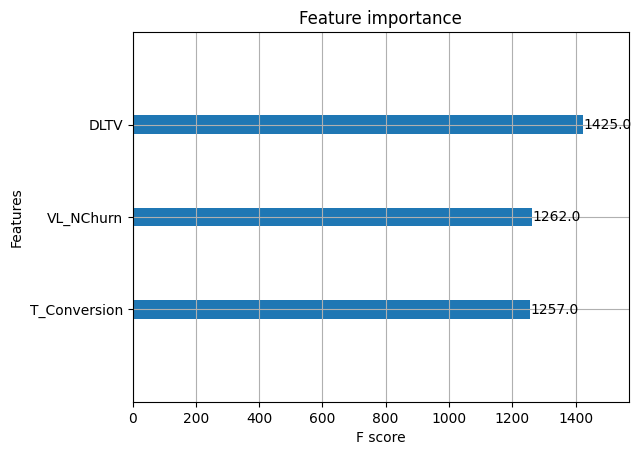

In [25]:
graficar(df_segmentado, model_cols)
graficar_importancia(df_segmentado, model_cols)

#### Caracterizar Segmentos

In [26]:
# suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format
# Mostrar estadísticas de los clusters
df_segmentado[model_cols+['cluster']].groupby('cluster').describe().T

cluster                     0          1          2
DLTV         count   13312.00    6939.00    2585.00
             mean   312376.58 1136590.28  782756.22
             std    170686.46  388471.67  485524.01
             min     10114.55  175739.95   17715.27
             25%    181118.21  853827.30  405397.33
             50%    274141.19 1085501.91  676282.77
             75%    434845.73 1402088.07 1049605.18
             max   1498004.31 2036851.85 2032501.04
T_Conversion count   13312.00    6939.00    2585.00
             mean       87.92      96.23    1984.94
             std       200.47     215.43     851.75
             min      -426.00    -318.00     873.00
             25%         9.00      10.00    1383.00
             50%        22.00      23.00    1727.00
             75%        48.00      47.00    2357.00
             max      1658.00    1470.00    6492.00
VL_NChurn    count   13312.00    6939.00    2585.00
             mean        0.59       0.15       0.33
             std         0.20       0.15       0.14
             min         0.03       0.01       0.01
             25%         0.41       0.01       0.24
             50%         0.57       0.03       0.30
             75%         0.76       0.30       0.37
             max         1.00       0.72       1.00

In [19]:
df_ocupaciones = pd.read_csv('Ocupaciones.csv')
df_ocupaciones.head()

,Ocupacion_Actual,Ocupacion_Limpia
0,Abogado,Abogado
1,Administrador,Administrador
2,Ama de Casa,Ama de Casa
3,Analista de Proceso,Analista de Procesos
4,Analista de Procesos,Analista de Procesos


In [24]:
df_donantes['FK_ID_Ocupacion'] = df_donantes['FK_ID_Ocupacion'].replace(list(df_ocupaciones['Ocupacion_Actual']), list(df_ocupaciones['Ocupacion_Limpia']))
df_donantes['FK_ID_Ocupacion'].value_counts()

0                        4852
Empleado                 2987
Ingeniero                2972
Administrador            1531
Profesor                 1004
                         ... 
MÚSICO                     1
OPTÓMETRO                  1
Terapeuta ocupacional       1
Gastroenterólogo            1
ANTROPÓLOGO                1
Name: FK_ID_Ocupacion, Length: 107, dtype: int64